In [2]:
import numpy as np
import pandas as pd
import mysql.connector as sql
from IPython.display import clear_output
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
import datetime
stop_words = set(stopwords.words('english'))
import re
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

In [3]:
print(sql.__version__)

8.0.33


# Data Preprocessing

In [4]:
df=pd.read_csv('chatbotData.csv')
df.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [5]:
print(df.size)

6228


In [6]:
df

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts
...,...,...,...
2071,How much interest did I earn in Q4 of this year?,NaN,NaN
2072,What is the interest earned on my account duri...,NaN,NaN
2073,Can you show me a breakdown of the interest ea...,NaN,NaN
2074,What is the interest earned on my account for ...,NaN,NaN


In [7]:
df['Class'] = df['Class'].fillna('Transaction')

In [8]:
df.dtypes

Question    object
Answer      object
Class       object
dtype: object

In [9]:
df.head(10)

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts
5,What are the documents required for opening Cu...,Following documents are required for opening C...,accounts
6,Who can be a partner in a partnership firm,"Partners must be major (above the age of 18), ...",accounts
7,What is the time taken to realize outstation c...,The indicative time taken for the realization ...,accounts
8,Can an individual open a Current Account,Yes. Documentation will be that of an individu...,accounts
9,Can EEFC Account be opened by Special Economic...,"No, SEZ Units cannot open EEFC accounts.",accounts


In [10]:
def cleanup(review):
    review = re.sub('[^a-zA-Z]', ' ', review)
    
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    all_stopwords.append('bank')
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(all_stopwords)]
#     print(type(review))
#     print(len(review))
#     print(review)
    corpus.append(review)
    df['Question'][i]=' '.join(review)
    return ' '.join(review) 

In [11]:
corpus=[]

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X=[]
m=0
y=[]
#preparing X and y to use
print(len(df))
for i in range(len(df)):
  m=max(m,len(df['Question'][i]))
  X.append(cleanup(df['Question'][i]))
  y.append(df['Class'][i])
print(m)

2076
210


In [13]:
print(type(X))
print(len(X))
print(len(y))

<class 'list'>
2076
2076


In [14]:
print(corpus)

[['document', 'required', 'opening', 'current', 'account', 'sole', 'proprietorship', 'firm'], ['transfer', 'current', 'account', 'one', 'branch', 'another'], ['present', 'status', 'nri', 'extra', 'document', 'required', 'opening', 'sole', 'proprietorship', 'current', 'account'], ['document', 'required', 'opening', 'current', 'account', 'limited', 'liability', 'partnership'], ['document', 'required', 'change', 'address', 'entity'], ['document', 'required', 'opening', 'current', 'account', 'company'], ['partner', 'partnership', 'firm'], ['time', 'taken', 'realize', 'outstation', 'cheque'], ['individual', 'open', 'current', 'account'], ['eefc', 'account', 'opened', 'special', 'economic', 'zone', 'sez', 'unit'], ['case', 'unable', 'access', 'company', 'current', 'account'], ['transaction', 'included', 'part', 'free', 'inter', 'city', 'clearing', 'limit'], ['n', 'premium', 'ca', 'different', 'regular', 'ca', 'offered', 'bank'], ['must', 'open', 'premium', 'current', 'account', 'location', '

In [15]:
le = LabelEncoder()
y=le.fit_transform(y)

In [16]:
from collections import Counter
items = Counter(y).keys()
print(items)

dict_keys([1, 2, 3, 4, 5, 6, 7, 0])


In [17]:
df.groupby('Class').size()

Class
Transaction      304
accounts         314
cards            403
fundstransfer     14
insurance        469
investments      140
loans            375
security          57
dtype: int64

# APPLYING TF-IDF TO CONVERT TEXT TO NUMBERS

In [18]:
tfv = TfidfVectorizer(min_df=1, stop_words='english')
X=tfv.fit_transform(X)

In [19]:
x=tfv.transform(['account are very important'])
x
print(x.shape)
print(type(x))

(1, 1105)
<class 'scipy.sparse._csr.csr_matrix'>


# Splitting dataset to train model

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1764, 1105)
(1764,)
(312, 1105)
(312,)


# Training Model to predict the class of the query

In [22]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
print("SVC:", model.score(X_test, y_test))

SVC: 0.9391025641025641


In [23]:
y_pred=model.predict(X_test)

In [24]:
#Creating the confusion matrix and checking the accuracy
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_test,y_pred)
print(acc*100)
print (classification_report(y_test, y_pred) )

93.91025641025641
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       0.93      0.86      0.90        50
           2       1.00      0.93      0.96        55
           3       1.00      1.00      1.00         2
           4       0.90      0.97      0.94        75
           5       0.83      0.83      0.83        12
           6       0.95      0.95      0.95        61
           7       0.86      0.86      0.86         7

    accuracy                           0.94       312
   macro avg       0.93      0.93      0.93       312
weighted avg       0.94      0.94      0.94       312



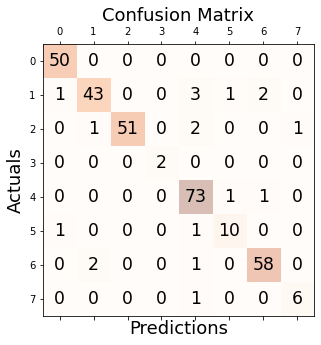

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


# Creating a Function which will return the response to query

In [26]:
def get_max5(arr):
    ixarr = []
    for ix, el in enumerate(arr):
        ixarr.append((el, ix))
    ixarr.sort()
    ixs = []
    for i in ixarr[-5:]:
        ixs.append(i[1])
    return ixs[::-1]

def get_response(usrText):
    while True:
        if usrText.lower() == "bye":
            return "Bye"
        GREETING_INPUTS = ["hello", "hi", "greetings", "sup", "what's up", "hey","hiii","hii","yo"]
        a = [x.lower() for x in GREETING_INPUTS]
        sd=["Thanks","Welcome"]
        d = [x.lower() for x in sd]
        am=["OK"]
        c = [x.lower() for x in am]
        qurstr=cleanup(usrText.strip().lower())
        t_usr = tfv.transform([cleanup(usrText)])
#         print(model.predict(t_usr))
#         print('----')
        class_ = le.inverse_transform(model.predict(t_usr))
#         print(class_)
        questionset = df[df['Class'].values == class_]
        
        cos_sims = []
        for question in questionset['Question']:
#             print(question,end=' ')
            sims = cosine_similarity(tfv.transform([question]), t_usr)
#             print(sims)
            cos_sims.append(sims)
        
        
        ind = cos_sims.index(max(cos_sims))
        b = [questionset.index[ind]]
        
        if usrText.lower() in a:

            return ("Hi, I'm Emily!\U0001F60A")

        if usrText.lower() in c:
            return "Ok...Alright!\U0001F64C"

        if usrText.lower() in d:
            return ("My pleasure! \U0001F607")

        if max(cos_sims) > [[0.]]:
            a = df['Answer'][questionset.index[ind]]
            if class_=='Transaction':
                return sqlquery(a,usrText,qurstr)
            else:
                return a
        elif max(cos_sims)==[[0.]]:
           return "sorry! \U0001F605"

# asking query 

In [27]:
get_response('loan policy')

'No policy loans are available for this product.'

In [28]:
get_response('How can i apply for a loan')

'Credila provides education loan to Indian students for higher studies in India and abroad. Credila has funded Indian students for pursuing higher studies in over 2000 institutes across 36 countries.'

In [29]:
get_response('document required to open a bank account')

'The indicative time taken for the realization of outstation cheques is given below: Cheques drawn where M&N  Bank has a branch, credit will be given on receipt of clear funds in: Main metro locations (Mumbai, Chennai, Kolkata, New Delhi): 7 working days Metro centers and state capitals (other than those of North Eastern states and Sikkim): Maximum period of 10 working days. In all other centres where we have branches: maximum period of 14 working days. Cheques drawn on non-branch locations where we have a tie-up with correspondent banks, credit will be given on receipt of clear funds: Within a maximum period of 14 working days Cheques drawn on non-branch locations where we do not have a tie-up with correspondent banks, credit will be given on receipt of clear funds: Within a maximum period of 14 working days For more details on the outstation cheque collection policy, click here. For other queries, Contact Us. View more'

In [30]:
get_response('process to open a bank account')

'The indicative time taken for the realization of outstation cheques is given below: Cheques drawn where M&N  Bank has a branch, credit will be given on receipt of clear funds in: Main metro locations (Mumbai, Chennai, Kolkata, New Delhi): 7 working days Metro centers and state capitals (other than those of North Eastern states and Sikkim): Maximum period of 10 working days. In all other centres where we have branches: maximum period of 14 working days. Cheques drawn on non-branch locations where we have a tie-up with correspondent banks, credit will be given on receipt of clear funds: Within a maximum period of 14 working days Cheques drawn on non-branch locations where we do not have a tie-up with correspondent banks, credit will be given on receipt of clear funds: Within a maximum period of 14 working days For more details on the outstation cheque collection policy, click here. For other queries, Contact Us. View more'

# creating a sql query function which will deal with transaction related query of the customer

In [61]:
def sqlquery(qr,a,b):
    mydb= sql.connect(
     host='localhost',
     user='root',
     passwd="Sahil@123",
     database='chatbotdb',
     use_pure= True
    )
    userid= "1"
    cur= mydb.cursor()
    query = qr
#     print(query)
    allMonths = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
    monthArg=[]
    yearArg=[]
    #have to handle inputList
    inputList=[]
    for inp in inputList:
        if inp.lower() in allMonths:
            monthArg.append(inp.lower())
        elif inp.isnumeric() and len(inp)==4:
            yearArg.append(int(inp))
    if len(yearArg)==2 and yearArg[0]>yearArg[1]:
        return "Invalid Date Range"
    while len(monthArg)<2:
        monthArg.append("Dummy_Value")
    while len(yearArg)<2:
        yearArg.append("Dummy_Value")
    
    #monthArg and YearArg are two list which will keep the information taken out from query
    #We will keep the size of these two list as 2(Will pad with 0 if needed)
    query=query.replace("userIdArg", userid)
    query=query.replace("month1Arg", monthArg[0])
    query=query.replace("month2Arg", monthArg[1])
    query=query.replace("year1Arg", yearArg[0])
    query=query.replace("year2Arg", yearArg[1])
    

    cur.execute(query)
    data_bases = cur.fetchall()
#     print(type(data_bases))
    return data_bases

# creating a virtual interface to check if it is working 

In [62]:
flag= True
print("Enter your user id and password")
userid=input()
passwd=input()
passwd= "'" + passwd +"'"
# print(passwd)
# print(type(passwd))
mydb= sql.connect(
     host='localhost',
     user='root',
     passwd="Sahil@123",
     database='chatbotdb',
     use_pure= True
)
cur= mydb.cursor()

query= 'select count(*) from user where user_id='+ userid +' and first_name='+ passwd
# print(query)
cur.execute(query)

data_bases = cur.fetchall()
if(data_bases[0][0]==1):
    query= 'select * from user where user_id='+userid+' and first_name='+passwd
    cur.execute(query)

    data_bases = cur.fetchall()
    print('Hello', data_bases[0][2])
    flag=True
else:
    print('Wrong Credentials')


while(flag==True):
    user_response=input()
    user_response=user_response.lower()
    if(user_response!='bye'):
        if(user_response=='thanks'):
            flag=False
            print('You are Welcome')
        else:
            a=get_response(user_response)
            for i in range(len(a)):
                print(a[i])
    else:
        flag=False
        print('take care')

Enter your user id and password
1
john
Hello John
current balance
(2500,)
show my transactions
('1', '1', 10001, datetime.datetime(2022, 1, 15, 0, 0), 'Deposit', 1000, 'Grocery Store', 'Credit Card')
('11', '1', 10001, datetime.datetime(2022, 3, 5, 0, 0), 'Withdrawal', 500, 'ATM', 'Debit Card')
('16', '1', 10001, datetime.datetime(2022, 2, 20, 0, 0), 'Deposit', 2000, 'Retail Store', 'Credit Card')
('21', '1', 10001, datetime.datetime(2022, 1, 15, 0, 0), 'Deposit', 1000, 'Grocery Store', 'Credit Card')
('26', '1', 10001, datetime.datetime(2022, 2, 1, 0, 0), 'Deposit', 800, 'Retail Store', 'Debit Card')
('31', '1', 10001, datetime.datetime(2022, 3, 5, 0, 0), 'Withdrawal', 500, 'ATM', 'Debit Card')
('36', '1', 10001, datetime.datetime(2022, 2, 20, 0, 0), 'Deposit', 2000, 'Retail Store', 'Credit Card')
('6', '1', 10001, datetime.datetime(2022, 2, 1, 0, 0), 'Deposit', 800, 'Retail Store', 'Debit Card')
thanks
You are Welcome
